In [4]:
!nvidia-smi

isLocalServer = True
sys_path_to_be_added = '/notebook/personal/ksuchoi216/FaceID-model/'
config_path = './configs/config.json'

%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import os

def checkLocalServer(isLocalServer, sys_path_to_be_added=None):
    print(f'isLocalServer is {isLocalServer}')
    if isLocalServer is True:
        if sys_path_to_be_added not in sys.path:
            sys.path.insert(0, sys_path_to_be_added)
            os.chdir(sys_path_to_be_added)

        # print("System path as follows:")
        # for path in sys.path:
        #     print(f"{path}")

checkLocalServer(isLocalServer, sys_path_to_be_added)

from utils import Config_Manager
cfgm = Config_Manager(config_path)
cfg = cfgm.get_cfg()
!pwd

Thu Sep 29 13:38:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:04:00.0 Off |                    0 |
| N/A   33C    P0    33W / 250W |   1395MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:06:00.0 Off |                    0 |
| N/A   

# Loading model and data

In [2]:
from datasets import Folder_Dataset
from utils import imshow_dataloader

folder_Dataset = Folder_Dataset(cfg['embedding'])
dataloaders, dataset_sizes, idx_to_class = folder_Dataset.createDataLoaders()

phase="train"
for i, (img, label) in enumerate(dataloaders[phase]):
  if i >= 3:
    break
  plt.imshow(img)
  plt.axis('off')
  plt.show()
  print(f'label: {label}')  

KeyError: 'embedding'

In [47]:
from modules import Builder
import torchsummary

cfg = load_config('config_pca.json')
builder_classification = Builder(cfg['model_for_classification'])
builder_embedding = Builder(cfg['model_for_embedding'])
model_for_classification = builder_classification.loadModel('./data/face-extraction-model.pt', 'cpu')
model_for_embedding = builder_embedding.getModel('cpu').eval()
print(model_for_embedding)

device is cuda:0
Loading model was just completed.
device is cuda:0
Loading model was just completed.
InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, 

# Feature extraction and data transfromation

In [48]:
from external_library import MTCNN
face_detector = MTCNN(image_size=240, margin=0, keep_all=True, min_face_size=40)


from utils import imshow_denormalization
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# phases = ['train', 'val', 'test']
phases = ['test']
for phase in phases:
  print(f'phase: {phase}')
  
  image_list = []
  model_preds_list = []
  model_embs_list = []
  label_list = []
  
  for i, (img, label) in enumerate(dataloaders[phase]):
    face, _ = face_detector(img, return_prob = True)
    # print(face.shape)
    
    if face is not None:
      prods = model_for_classification(face)
      prods = torch.sigmoid(prods)
      _, pred = torch.max(prods, 1)
      pred = pred.numpy()
      
      # face = torch.squeeze(face)
      emb = model_for_embedding(face)
      emb = torch.squeeze(emb).numpy()
      
      if emb.shape[0] != 512:
        print(f'dimension errror - output.shape: {emb.shape[0]}')
      
      face = torch.squeeze(face).view(-1,).numpy()
              
      image_list.append(face)
      model_preds_list.append(pred)
      model_embs_list.append(emb)
      label_list.append(label)
  
    print(f'{i:4}... img shape: {face.shape} pred shape: {pred.shape} emb shape: {emb.shape} label: {label}')  
  
  path_for_image_data = './data/'+phase+'_image.npy'
  path_for_pred_data = './data/'+phase+'_pred.npy'
  path_for_emb_data = './data/'+phase+'_emb.npy'
  path_for_label_data = './data/'+phase+'_true.npy'
  
  image_numpy = np.array(image_list)
  pred_numpy = np.array(model_preds_list)
  emb_numpy = np.array(model_embs_list)
  label_numpy = np.array(label_list)
  
  np.save(path_for_image_data, image_numpy, allow_pickle=True)
  np.save(path_for_pred_data, pred_numpy, allow_pickle=True)
  np.save(path_for_emb_data, emb_numpy, allow_pickle=True)
  np.save(path_for_label_data, label_numpy, allow_pickle=True)
  # print(len(data_list))
  print(f'{phase}_image.npy saved in {path_for_image_data}')
  print(f'{phase}_pred.npy saved in {path_for_pred_data}')
  print(f'{phase}_emb.npy saved in {path_for_emb_data}')
  print(f'{phase}_label.npy saved in {path_for_label_data}')
  
  print('\n')  

phase: test
   0... img shape: (172800,) pred shape: (1,) emb shape: (512,) label: 0
   1... img shape: (172800,) pred shape: (1,) emb shape: (512,) label: 0
   2... img shape: (172800,) pred shape: (1,) emb shape: (512,) label: 0
   3... img shape: (172800,) pred shape: (1,) emb shape: (512,) label: 0
   4... img shape: (172800,) pred shape: (1,) emb shape: (512,) label: 0
   5... img shape: (172800,) pred shape: (1,) emb shape: (512,) label: 0
   6... img shape: (172800,) pred shape: (1,) emb shape: (512,) label: 0
   7... img shape: (172800,) pred shape: (1,) emb shape: (512,) label: 0
   8... img shape: (172800,) pred shape: (1,) emb shape: (512,) label: 0
   9... img shape: (172800,) pred shape: (1,) emb shape: (512,) label: 0
  10... img shape: (172800,) pred shape: (1,) emb shape: (512,) label: 0
  11... img shape: (172800,) pred shape: (1,) emb shape: (512,) label: 0
  12... img shape: (172800,) pred shape: (1,) emb shape: (512,) label: 0
  13... img shape: (172800,) pred shape

In [31]:
phase = phases[0]

source = './data/'
path_x_img = source + phase + '_image.npy'
x_img = np.load(path_x_img, allow_pickle=True)

path_x_emb = source + phase +'_emb.npy'
x_emb = np.load(path_x_emb, allow_pickle=True)

path_y_pred = source + phase +'_pred.npy'
y_pred = np.squeeze(np.load(path_y_pred, allow_pickle=True))

path_y_true = source + phase + '_true.npy'
y_true = np.load(path_y_true, allow_pickle=True)

# val_path = source + 'val.npy'
# test_path = source + 'test.npy'


print(f'images shape: {x_img.shape} embedding: {x_emb.shape} pred: {y_pred.shape} y: {y_true.shape}')

images shape: (16, 172800) embedding: (16, 512) pred: (16,) y: (16,)


# PCA

In [43]:
#multiple numpy to dataframe
import pandas as pd
from utils import pca

pca_x1_img, pca_x2_img = execute_pca(x_img)
pca_x1_emb, pca_x2_emb = execute_pca(x_emb)

error = np.where(y_true == y_pred, 0, 1)
print(error)
print(y_true)
print(y_pred)
combined_array = np.column_stack((pca_x1_img, pca_x2_img, pca_x1_emb, pca_x2_emb, y_pred, y_true, error))
data_for_pca = pd.DataFrame(combined_array, columns = ['pca_x1_img', 'pca_x2_img', 'pca_x1_emb', 'pca_x2_emb', 'y_pred', 'y_true', 'error'])

[0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 3 0 0 2 0 0 0 0 0 0 0]


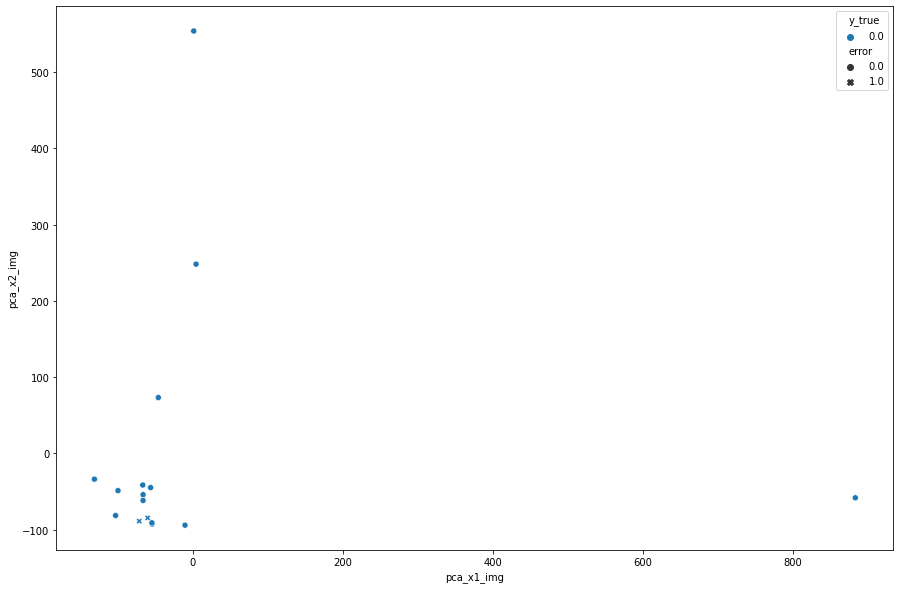

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

label_list = ['jhyoo', 'jhoh', 'jhongyoo', 'kschoi']

fig = plt.figure(1, figsize=(15, 10))
sns.scatterplot(data=data_for_pca, x='pca_x1_img', y='pca_x2_img', hue='y_true', style='error')
plt.show()

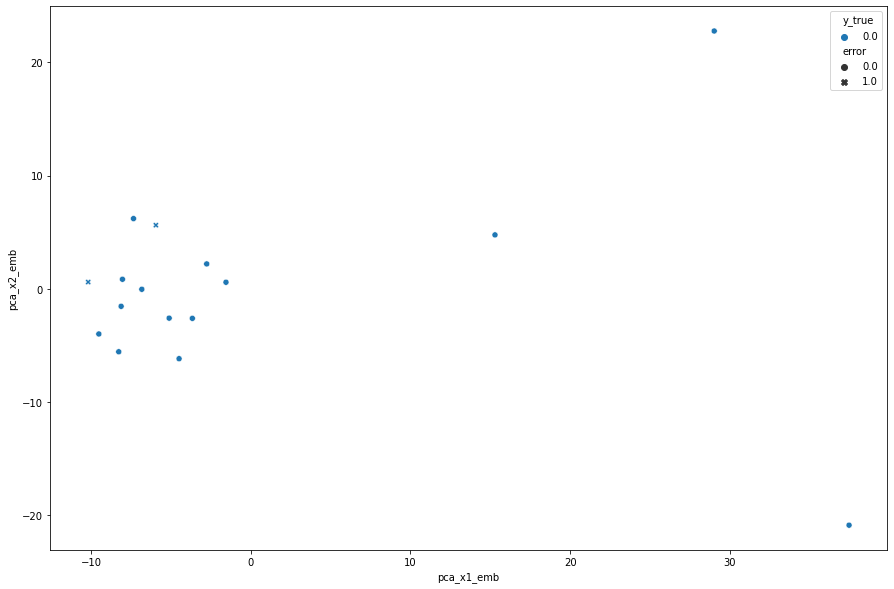

In [42]:
fig = plt.figure(1, figsize=(15, 10))
sns.scatterplot(data=data_for_pca, x='pca_x1_emb', y='pca_x2_emb', hue='y_true', style='error')
plt.show()